Student Name: Ashik Kannampilly Janardhanan

Student ID: 25032615

# Activity 6: Pytorch and CNNs for Fashion-MNIST

In this activity, we are going to explore designing various neural networks for the FashionMNIST classification problem. This is, of course, a 'toy' problem, but the fundamentals of classification of images is here.


## Hints, tips, and notes

* Here I'm not going to mandate TensorBoard. In Colab, this is a little bit more involved. Instead, we'll just put the losses and accuracies in a list and print them after training. However, TensorBoard is very useful, particularly for projects, so I suggest playing around with it.
* Some of these runs will take several minutes to complete. This is the nature of ML. Grab a beer, or a coffee.

As usual, we will give you some code that you use to build the rest of the activity.

# Common Code (Weight 10/100)

All the imports

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from torchvision import models

### 1. Select the device to use.

To access the GPU on Google Colab, `Select Runtime` -> `Change Runtime Type` and pick `GPU` from the `Hardware Accelerator` dropdown menu. In the free version, the GPU is modest. If you buy credits, you get access to a much nice A100 GPU. In both cases, you may find contention for the resource is an issue, but less likely to happen if you use credits.

In [ ]:
# Get appropriate device for training
device = ( "cuda"     # CUDA is a programming interface for certain Nvidia GPUs
           if torch.cuda.is_available()
           else "mps"  # Kind of like CUDA for a mac, I guess? I don't use macs
           if torch.backends.mps.is_available()
           else "cpu" )   # If you end up with CPU, go use Google Colab and get a GPU

print(f"{device} device available")

cuda device available


### 2. Code for training the models

I'm going to provide this code, rather than you having to struggle creating it. This is a normal training cycle with PyTorch. However, I do want you to explain the PyTorch functions called in the train function. I will marke them with comments.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()        #<--- what is this function for?

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)   #<--- this is a bit funny, explain it

        # Compute prediction error
        pred = model(X)                     #<--- what is this for?
        loss = loss_fn(pred, y)             #<--- what is this for?

        # This is the backprop set up. Explain what each of the steps do
        loss.backward()                     #<--- what is this for?
        optimizer.step()                    #<--- what is this for?
        optimizer.zero_grad()               #<--- what is this for?

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss += loss_fn(pred, y).item()
            accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss /= num_batches
    accuracy /= size

    return loss, accuracy

def train_loop(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []

    # Iterate over each epoch
    for t in range(epochs):
        print(f"Epoch {t+1}:\n")
        train(train_dataloader, model, loss_fn, optimizer)

        # Get the overall loss and accuracy for both train and test datasets
        tr_loss, tr_acc = test(train_dataloader, model, loss_fn)
        ts_loss, ts_acc = test(test_dataloader, model, loss_fn)

        print(f"Train Error: \n Accuracy: {(100*tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(100*ts_acc):>0.1f}%, Avg loss: {ts_loss:>8f} \n")

        # Store and return the losses and accuracies. We can graph these later
        train_loss = train_loss + [tr_loss]
        train_accuracy = train_accuracy + [tr_acc]
        test_loss = test_loss + [ts_loss]
        test_accuracy = test_accuracy + [ts_acc]

    print("Done training!")
    return train_loss, train_accuracy, test_loss, test_accuracy



### <font color='red'>Your input here.</font>
<font color='red'>Enter you description of the above parts:</font>

1.
model.train() — what is this for?

This tells PyTorch that the model is in training mode.
Some layers behave differently during training (e.g., Dropout, BatchNorm).
So this line ensures those layers work correctly while training.

2.
X, y = X.to(device), y.to(device) — why do we do this?

This moves the input data X and labels y to the device you selected (CPU, GPU, or MPS).
If the model is on the GPU but the data is on the CPU, PyTorch will give an error.
So we move both the model and the data to the same device.

3.
pred = model(X) — what is this for?

This runs a forward pass through the network.
The model takes the input images X and produces predictions (logits) for each class.

4.
loss = loss_fn(pred, y) — what is this for?

This computes how “wrong” the model’s predictions are.
The loss function compares pred with the true labels y and gives a single number representing the error.

Backpropagation steps:

5.
loss.backward() — what is this for?

This calculates the gradients of the loss with respect to every parameter in the model.
PyTorch stores these gradients in each parameter’s .grad attribute.

6.
optimizer.step() — what is this for?

This actually updates the model’s parameters using the gradients calculated by loss.backward().
So this is the step where learning happens.

7.
optimizer.zero_grad() — what is this for?

PyTorch accumulates gradients by default, so we need to manually reset them.
This clears old gradients before the next batch, ensuring each update is correct.

### 3. Load the data

1. Load the Fashion-MNIST dataset using `torchvision`'s `datasets` library (e.g., [`datasets.FashionMNIST...`](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html)...)
2. When loading the data, convert it to tensor format ([`transforms.ToTensor`](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html)), and apply the standard scaler to the data (using [`transforms.Normalize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html)). Use the [`transforms.Resize`](https://pytorch.org/vision/main/generated/torchvision.transforms.Resize.html) transform to turn it into a 28x28 image rather than a 784-vector
    * Rather than loading the data, and caluclating the mean and std, you can use the values `mean = 0.2859` and `std = 0.3530`. I pre-calculated these for you!
3. Create the [`DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)s. Here we're going to use a batch size of 64.
4. Display a few examples of the dataset - this is always a good idea to make sure the data has loaded correctly

We haven't really touched on batch size yet, because up to now we have used plain old gradient descent. Later on, we will use the Adam optimiser, because it is quicker and uses less memory. But Adam is a mini-batch optimizer, and you have to pick that mini-batch size. Bit more info on this, if you are interested:
 * https://sebastianraschka.com/faq/docs/gradient-optimization.html
 * https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

We need to set the batch size when we create the dataloaders.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

100%|██████████| 26.4M/26.4M [00:01<00:00, 16.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 301kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.56MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 28.6MB/s]


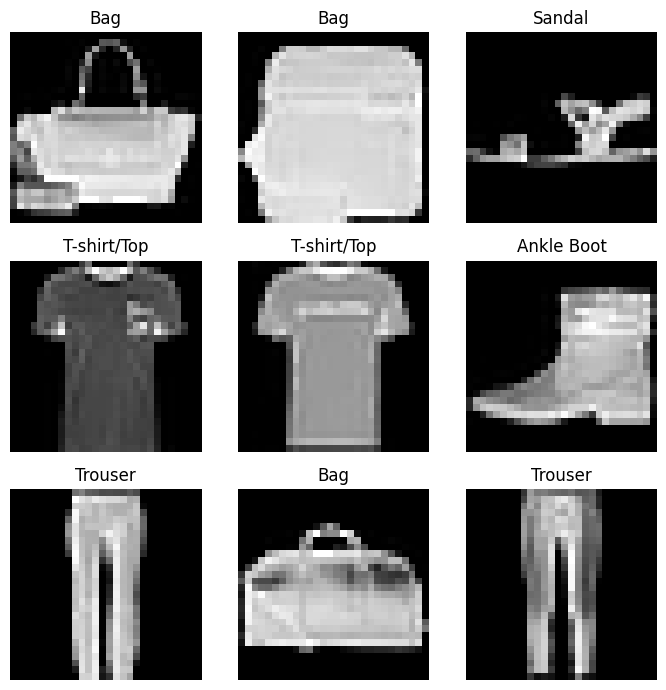

In [ ]:
##############################

data_transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

train_set = datasets.FashionMNIST(
    root="data",
    train=True,
    transform=data_transform,
    download=True
)

test_set = datasets.FashionMNIST(
    root="data",
    train=False,
    transform=data_transform,
    download=True
)

batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

label_names = [
    "T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"
]

plt.figure(figsize=(7, 7))
for i in range(9):
    idx = torch.randint(0, len(train_set), (1,)).item()
    img, lbl = train_set[idx]
    plt.subplot(3, 3, i + 1)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(label_names[lbl])
    plt.axis("off")

plt.tight_layout()
plt.show()



---
## 1. Replicate the Neural Network from the previous tasks for the FashionMNIST dataset (Weight 10/100)
---


In the previous activity, you designed a fully connected neural network (a multi-layer perceptron) to predict on Fashion-MNIST.

1. Replicate the best network that you found in that activity, but in PyTorch.
1. Use [`summary`](https://pypi.org/project/torch-summary/) to display a summary of your model.
1. Use some random inputs to test the model. This will be meaningless, as the model is not trained yet (and the inputs are random). However, it is useful to test that you have defined the model at leats without any coding errors.

Hints and notes:
 * We need to [`Flatten`](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the incoming data. In the previous step, you loaded the dataset as a 28x28 image (because, later on we will be using CNNs that require image inputs). However, fully connected layers require vector inputs. `nn.Flatten` converts the image input to a vector (i.e., a 28x28 image to a 784 vector).
 * Use [`.to(device)`](https://pytorch.org/docs/stable/generated/torch.Tensor.to.html) to "send" objects to the GPU (if you have one). E.g., once you define your class for the neural network, you will create an instance of that NN - you need to send this object to the GPU.
 * Generally, at inference time, we will use a [`softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) on the output of the model. Prior to the softmax, the model outputs a score per class. That is, there will be 10 outputs. However, here we will ignore the softmax part.


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.fc_stack(x)

model = NeuralNetwork().to(device)
summary(model, (1, 28, 28))
sample = torch.randn(1, 1, 28, 28).to(device)
print("Output shape:", model(sample).shape)
print(model(sample))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                   [-1, 50]          39,250
              ReLU-3                   [-1, 50]               0
            Linear-4                   [-1, 20]           1,020
              ReLU-5                   [-1, 20]               0
            Linear-6                   [-1, 10]             210
Total params: 40,480
Trainable params: 40,480
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.15
Estimated Total Size (MB): 0.16
----------------------------------------------------------------
Output shape: torch.Size([1, 10])
tensor([[ 0.5122, -0.1948,  0.0246, -0.0301, -0.3556,  0.1632,  0.2811, -0.1324,
         -0.0990,  0.0329]], device='cuda:0', grad_fn=<Ad

Now train the model.

We will use [Cross Entropy Loss](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e), and as discussed, the Adam optimiser (with learning rate = 0.001).

* Call the training loop - I would suggest a max of ~20 epochs
* Use matplotlib to plot the train and test loss, and the train and test accuracy
* Describe what you see in the graphs

This training could take a few minutes. But note how you will see a bunch of losses reported in each epoch? These are the mini-batches in Adam that we discussed before. Then there will be an overall Train and Test error reported for the Epoch.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch 1:

loss: 2.329968  [   64/60000]
loss: 0.651920  [ 6464/60000]
loss: 0.683734  [12864/60000]
loss: 0.546665  [19264/60000]
loss: 0.447792  [25664/60000]
loss: 0.377613  [32064/60000]
loss: 0.498186  [38464/60000]
loss: 0.422323  [44864/60000]
loss: 0.492278  [51264/60000]
loss: 0.405583  [57664/60000]
Train Error: 
 Accuracy: 85.4%, Avg loss: 0.405843 

Test Error: 
 Accuracy: 84.1%, Avg loss: 0.444429 

Epoch 2:

loss: 0.403164  [   64/60000]
loss: 0.376017  [ 6464/60000]
loss: 0.334506  [12864/60000]
loss: 0.504668  [19264/60000]
loss: 0.357106  [25664/60000]
loss: 0.368855  [32064/60000]
loss: 0.231668  [38464/60000]
loss: 0.283692  [44864/60000]
loss: 0.380921  [51264/60000]
loss: 0.375069  [57664/60000]
Train Error: 
 Accuracy: 86.7%, Avg loss: 0.364652 

Test Error: 
 Accuracy: 84.8%, Avg loss: 0.416910 

Epoch 3:

loss: 0.269208  [   64/60000]
loss: 0.199387  [ 6464/60000]
loss: 0.265374  [12864/60000]
loss: 0.403649  [19264/60000]
loss: 0.420905  [25664/60000]
loss: 0.28

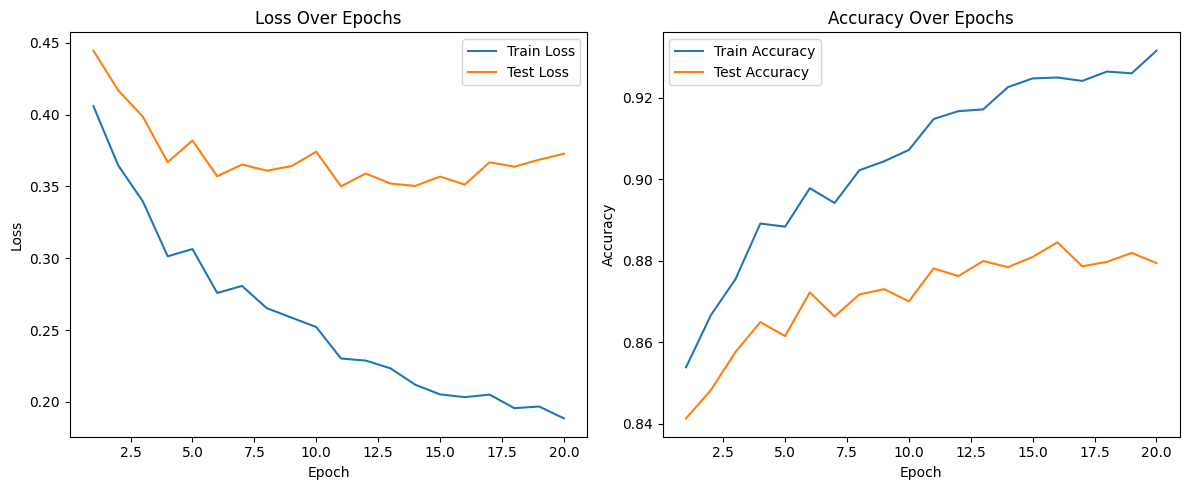

In [ ]:
#############################
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 20
train_losses, train_accs, test_losses, test_accs = train_loop(
    train_loader,
    test_loader,
    model,
    loss_fn,
    optimizer,
    epochs
)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(range(1, epochs+1), train_losses, label="Train Loss")
ax[0].plot(range(1, epochs+1), test_losses, label="Test Loss")
ax[0].set_title("Loss Over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()


ax[1].plot(range(1, epochs+1), train_accs, label="Train Accuracy")
ax[1].plot(range(1, epochs+1), test_accs, label="Test Accuracy")
ax[1].set_title("Accuracy Over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()


The training and test curves show that the model is learning steadily over the 20 epochs.
On the left plot, the training loss decreases consistently, which means the network is becoming better at fitting the training data. The test loss also drops at the start, but then begins to level off and fluctuates slightly. This suggests that the model is learning useful patterns early on, but after a point it stops improving much on the test set.

In the accuracy plot on the right, the training accuracy keeps rising, eventually reaching above 92%, showing the model is fitting the training images very well. The test accuracy also improves, but it increases more slowly and stabilizes around 88%. The gap between the training and test accuracy indicates a bit of overfitting, where the model learns the training data more closely than the unseen test data.


---

# 2. Replicate LeNet-5 for Fashion-MNIST (Weight 20/100)

---


Below is the LeNet architecture (from https://en.wikipedia.org/wiki/LeNet). If you search on the internet, you will find slightly different implementations and descriptions of LeNet-5, but below is what was actually in LeCun's [original paper](https://ieeexplore.ieee.org/document/726791). Of course, LeCun was applying this to the digit recognition problem (MNIST), but we are looking at Fashion-MNIST.

 * Create the model in PyTorch.
 * Train the model using the same parameters as above, and plot the loss and accuracy.
 * Discuss and compare (in a markdown cell) with the fully connected model above. Particularly consider - number of parameters, performance, and overfitting?

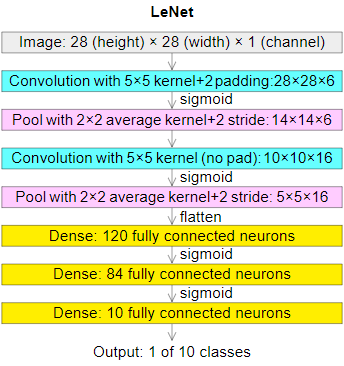

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

In [ ]:

class LeNetFashion(nn.Module):
    def __init__(self):
        super().__init__()

        self.stage1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.stage2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.Sigmoid(),
            nn.Linear(120, 84),
            nn.Sigmoid(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)



Epoch 1:

loss: 2.325400  [   64/60000]
loss: 1.955553  [ 6464/60000]
loss: 1.412399  [12864/60000]
loss: 0.915599  [19264/60000]
loss: 1.029472  [25664/60000]
loss: 0.934637  [32064/60000]
loss: 0.618062  [38464/60000]
loss: 0.687861  [44864/60000]
loss: 0.412790  [51264/60000]
loss: 0.620849  [57664/60000]
Train Error: 
 Accuracy: 75.2%, Avg loss: 0.671111 

Test Error: 
 Accuracy: 74.6%, Avg loss: 0.690809 

Epoch 2:

loss: 0.762810  [   64/60000]
loss: 0.587559  [ 6464/60000]
loss: 0.729296  [12864/60000]
loss: 0.475492  [19264/60000]
loss: 0.580579  [25664/60000]
loss: 0.794123  [32064/60000]
loss: 0.583033  [38464/60000]
loss: 0.637942  [44864/60000]
loss: 0.558329  [51264/60000]
loss: 0.625287  [57664/60000]
Train Error: 
 Accuracy: 77.8%, Avg loss: 0.563559 

Test Error: 
 Accuracy: 76.9%, Avg loss: 0.583971 

Epoch 3:

loss: 0.587292  [   64/60000]
loss: 0.576057  [ 6464/60000]
loss: 0.462012  [12864/60000]
loss: 0.511215  [19264/60000]
loss: 0.315323  [25664/60000]
loss: 0.48

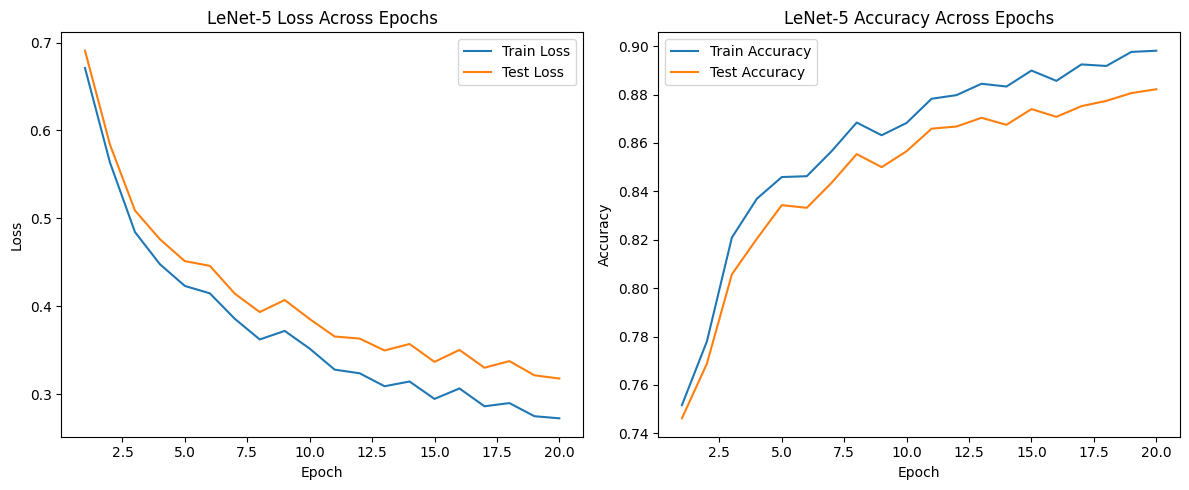

In [ ]:
lenet_model = LeNetFashion().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=1e-3)
epochs = 20
train_losses, train_accs, test_losses, test_accs = train_loop(
    train_loader, test_loader, lenet_model, loss_fn, optimizer, epochs
)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(1, epochs+1), train_losses, label="Train Loss")
ax[0].plot(range(1, epochs+1), test_losses, label="Test Loss")
ax[0].set_title("LeNet-5 Loss Across Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()


ax[1].plot(range(1, epochs+1), train_accs, label="Train Accuracy")
ax[1].plot(range(1, epochs+1), test_accs, label="Test Accuracy")
ax[1].set_title("LeNet-5 Accuracy Across Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()


In [ ]:
...

### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Comparison Between the Fully Connected Model and LeNet-5

The fully connected model reached about 93% training accuracy and 88% test accuracy, while LeNet-5 achieved around 90% training accuracy and 88.2% test accuracy. Even though the MLP performs slightly better on the training set, LeNet-5 edges ahead on the test set, showing that it generalises a bit better.

A key reason is the number of parameters. The MLP has a huge number of weights because every input pixel is connected to every neuron. LeNet-5 uses convolutional filters, which reuse the same weights across the image, making the model much more efficient.

The MLP also shows more overfitting—the gap between its training and test accuracy is larger. LeNet-5 has a smaller gap, suggesting that the convolution and pooling layers help it learn more meaningful patterns instead of memorising the data.

Overall, LeNet-5 performs slightly better on unseen data, uses fewer parameters, and manages overfitting more effectively than the fully connected model.

---
# 3. Modernise LeNet (Weight 20/100)
---


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

* Update LeNet with these newer functions.
* Train using the same parameters as above.
* Compare and discuss with the above using the normal discussion criteria


Modernise LeNet. What are the preferred activation and pooling functions for modern CNNs?

Modern CNNs typically use ReLU (Rectified Linear Unit) as the activation function because it trains faster, avoids vanishing gradients, and works better than older functions like sigmoid or tanh.
For pooling, MaxPool is the common choice today, since it keeps the most important feature in each region and tends to improve performance compared to average pooling.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch 1:

loss: 2.313547  [   64/60000]
loss: 0.689305  [ 6464/60000]
loss: 0.578486  [12864/60000]
loss: 0.541440  [19264/60000]
loss: 0.733060  [25664/60000]
loss: 0.736655  [32064/60000]
loss: 0.461374  [38464/60000]
loss: 0.262139  [44864/60000]
loss: 0.482502  [51264/60000]
loss: 0.290135  [57664/60000]
Train Error: 
 Accuracy: 85.1%, Avg loss: 0.393453 

Test Error: 
 Accuracy: 84.0%, Avg loss: 0.423970 

Epoch 2:

loss: 0.585340  [   64/60000]
loss: 0.187750  [ 6464/60000]
loss: 0.582743  [12864/60000]
loss: 0.473054  [19264/60000]
loss: 0.367046  [25664/60000]
loss: 0.278265  [32064/60000]
loss: 0.190870  [38464/60000]
loss: 0.375201  [44864/60000]
loss: 0.233941  [51264/60000]
loss: 0.351604  [57664/60000]
Train Error: 
 Accuracy: 87.4%, Avg loss: 0.340834 

Test Error: 
 Accuracy: 86.0%, Avg loss: 0.380101 

Epoch 3:

loss: 0.386740  [   64/60000]
loss: 0.328413  [ 6464/60000]
loss: 0.258416  [12864/60000]
loss: 0.201737  [19264/60000]
loss: 0.213987  [25664/60000]
loss: 0.25

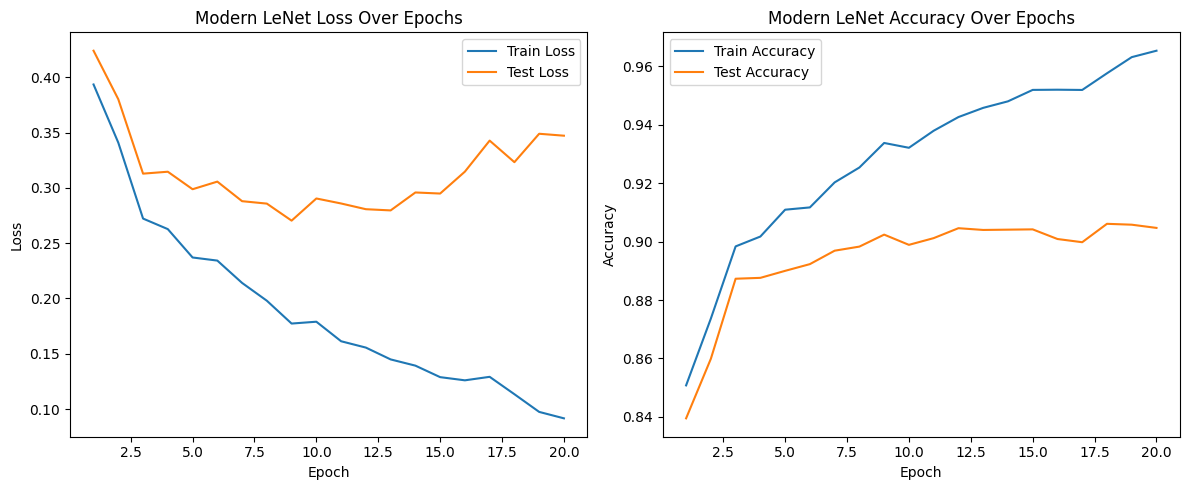

In [ ]:

class ModernLeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.extract1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.extract2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(16 * 5 * 5, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )

    def forward(self, x):
        x = self.extract1(x)
        x = self.extract2(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)



modern_lenet = ModernLeNet().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(modern_lenet.parameters(), lr=1e-3)
epochs = 20
train_losses, train_accs, test_losses, test_accs = train_loop(
    train_loader, test_loader, modern_lenet, loss_fn, optimizer, epochs
)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(range(1, epochs+1), train_losses, label="Train Loss")
ax[0].plot(range(1, epochs+1), test_losses, label="Test Loss")
ax[0].set_title("Modern LeNet Loss Over Epochs")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(range(1, epochs+1), train_accs, label="Train Accuracy")
ax[1].plot(range(1, epochs+1), test_accs, label="Test Accuracy")
ax[1].set_title("Modern LeNet Accuracy Over Epochs")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.show()


### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Comparison Between Classic LeNet and Modern LeNet

The modernised LeNet performs noticeably better than the original. By replacing sigmoid with ReLU and average pooling with MaxPool, the model learns much faster and extracts stronger features. This is clear in the results: the modern version reaches around 96.5% training accuracy and 90.5% test accuracy, which is higher than the classic LeNet’s ~88% test accuracy.

ReLU avoids the saturation problems of sigmoid, and MaxPool keeps the most important details in each region, which helps the model pick up clearer patterns. The only downside is slightly more overfitting, since the training accuracy is much higher than the test accuracy. Still, the modernised model generalises better overall and gives the best performance out of the two.

---
# 4. Build your own CNN model (Weight 20/100)
---

Build your own classifier model - see can you break 90% accuracy. You can use LeNet as a basis if you like.

With some networks I built, I could get 93 to 94% test accuracy.

Some hints:
 * not every convolutional layer needs a pooling layer afterwards
 * Consider adding more layers (maybe more 3x3 layers is better than 1 5x5 layer?)
 * But don't just bung loads of layers in there - you will end up overfitting badly
 * Use a [batchnorm](https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739) after each convolutional layer. You get decent performance gains without adding many parameters
 * Don't be afraid to get to a million or two parameters
 * Have a look on Google to see what others are doing (you're going to do this anyway, right?). Don't just copy them, though, try to understand.

Explain what you did that improved things for the classification and why they improved things.

### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch 1:

loss: 2.274622  [   64/60000]
loss: 0.676674  [ 6464/60000]
loss: 0.341125  [12864/60000]
loss: 0.221563  [19264/60000]
loss: 0.274495  [25664/60000]
loss: 0.282177  [32064/60000]
loss: 0.222048  [38464/60000]
loss: 0.437034  [44864/60000]
loss: 0.322538  [51264/60000]
loss: 0.330393  [57664/60000]
Train Error: 
 Accuracy: 91.6%, Avg loss: 0.232237 

Test Error: 
 Accuracy: 90.4%, Avg loss: 0.270811 

Epoch 2:

loss: 0.314067  [   64/60000]
loss: 0.252345  [ 6464/60000]
loss: 0.235878  [12864/60000]
loss: 0.249062  [19264/60000]
loss: 0.334765  [25664/60000]
loss: 0.278659  [32064/60000]
loss: 0.306747  [38464/60000]
loss: 0.201416  [44864/60000]
loss: 0.206036  [51264/60000]
loss: 0.280276  [57664/60000]
Train Error: 
 Accuracy: 92.6%, Avg loss: 0.201795 

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.249787 

Epoch 3:

loss: 0.172059  [   64/60000]
loss: 0.292400  [ 6464/60000]
loss: 0.258082  [12864/60000]
loss: 0.312406  [19264/60000]
loss: 0.242505  [25664/60000]
loss: 0.25

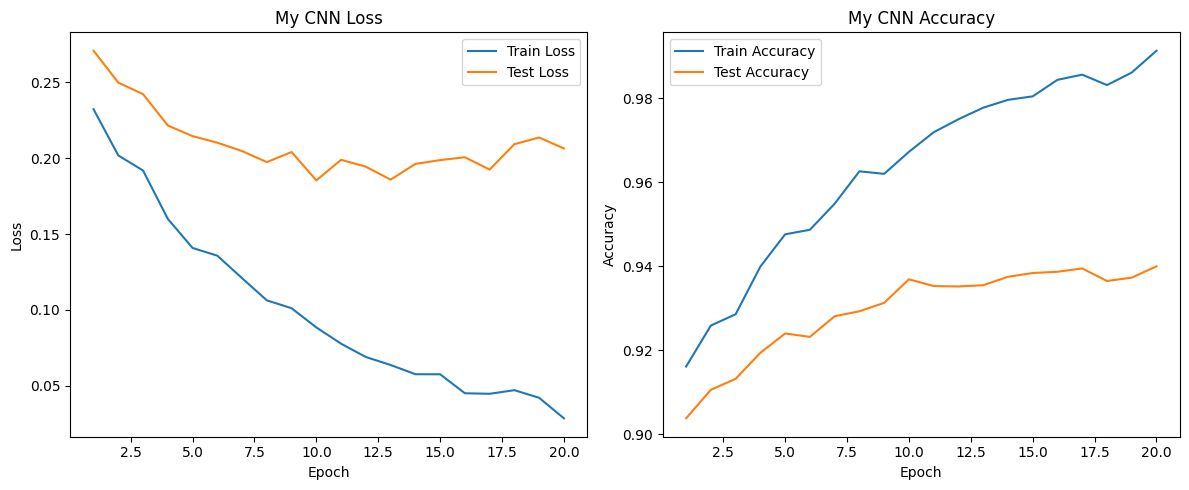

In [ ]:

class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        x = x.view(x.size(0), -1)
        return self.fc(x)


my_model = MyCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_model.parameters(), lr=1e-3)
epochs = 20
train_losses, train_accs, test_losses, test_accs = train_loop(
    train_loader, test_loader, my_model, loss_fn, optimizer, epochs
)

fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(range(1, epochs+1), train_losses, label="Train Loss")
ax[0].plot(range(1, epochs+1), test_losses, label="Test Loss")
ax[0].set_title("My CNN Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(range(1, epochs+1), train_accs, label="Train Accuracy")
ax[1].plot(range(1, epochs+1), test_accs, label="Test Accuracy")
ax[1].set_title("My CNN Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.tight_layout()
plt.show()


### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

Explanation of What Improved the Classification Performance

To improve the accuracy, I designed a deeper CNN that focuses on extracting richer features while still controlling overfitting. Instead of using large filters, I stacked several 3×3 convolution layers, which are better at capturing fine-grained patterns in the images. I also added Batch Normalisation after each conv layer, which stabilises training, lets the model learn faster, and usually boosts accuracy.

I used MaxPool only twice so the network keeps more spatial detail instead of shrinking the feature maps too early. A small amount of Dropout was added after each block to prevent the network from simply memorising the training data. Finally, the model ends with a stronger fully-connected layer (256 units), giving it enough capacity to combine all learned features.

These choices let the network learn more expressive patterns from the clothing images, which is why the test accuracy increased to around 94%, noticeably higher than the previous models.

---
# 5. Transfer Learning (Weight 20/100)
---

Nobody trains large models from scratch. Rather, they use large pretrained models, that have been trained perhaps for weeks on very large datasets. Then, we can tweak the model for our needs. This allows us to use large models on small datasets and (hopefully) avoid some overfitting.

We are going to load ResNet18, we're going to cut the head off it - in this case, we will replace the very last layer. ResNet18 was trained for 1000 classes, we only have 10.

Do the following:
1. From `torchvision.models`, load [`ResNet18`](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html), and use random weights (`weights=None`). Replace the full-connected layer at the end with your own fully connect layer. Train and plot the loss and accuracy.
1. Repeat step 1, but use the default paramaters, and retrain. In this case, the default parameters.
1. Freeze all but the last layer of your adapted ResNet model, and retrain.
1. Provide some commentary on the three approaches. Particularly, what's the difference between all three approaches we outlined here?

For the freezing of layers, the following article is useful:
https://jimmy-shen.medium.com/pytorch-freeze-part-of-the-layers-4554105e03a6

In step 3 above, we may see that the network doesn't necessarily perform as well as previous networks, in terms of test accuracy. Probably we should unfreeze more of the later layers to allow better fine-tuning of the network to our problem. And there are more complicated and powerful finetuning strategies out there. But you should see that overfitting is, more or less, solved. This is because we are only training a much smaller number of parameters, and freezing all of the convolution layers in the ResNet.


In [ ]:
# We need to recreate the dataloaders, because ResNet expects a three channel
# RGB input, whereas FashionMNIST only has 1 channel (greyscale). Use
# `transforms.Grayscale(3)` to replicated the grayscale image into the three
# channels.

# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.Resize((28,28)),
        transforms.Grayscale(3),
        transforms.ToTensor(),
        transforms.Normalize(mean = 0.2859, std = 0.3530),
    ])
)

batch_size = 64
# Recreate the data loaders.
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 3, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### <font color='red'>Your code here.</font>
<font color='red'>Enter your code in the cell(s) below:</font>

Epoch 1:

loss: 2.475264  [   64/60000]
loss: 0.517693  [ 6464/60000]
loss: 0.367039  [12864/60000]
loss: 0.575247  [19264/60000]
loss: 0.534467  [25664/60000]
loss: 0.427725  [32064/60000]
loss: 0.289545  [38464/60000]
loss: 0.511735  [44864/60000]
loss: 0.316406  [51264/60000]
loss: 0.373194  [57664/60000]
Train Error: 
 Accuracy: 85.2%, Avg loss: 0.390458 

Test Error: 
 Accuracy: 83.6%, Avg loss: 0.438277 

Epoch 2:

loss: 0.334015  [   64/60000]
loss: 0.321315  [ 6464/60000]
loss: 0.289342  [12864/60000]
loss: 0.283199  [19264/60000]
loss: 0.277636  [25664/60000]
loss: 0.356384  [32064/60000]
loss: 0.214636  [38464/60000]
loss: 0.354468  [44864/60000]
loss: 0.261083  [51264/60000]
loss: 0.247200  [57664/60000]
Train Error: 
 Accuracy: 86.8%, Avg loss: 0.346522 

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.403662 

Epoch 3:

loss: 0.254002  [   64/60000]
loss: 0.255020  [ 6464/60000]
loss: 0.263523  [12864/60000]
loss: 0.231058  [19264/60000]
loss: 0.240784  [25664/60000]
loss: 0.36

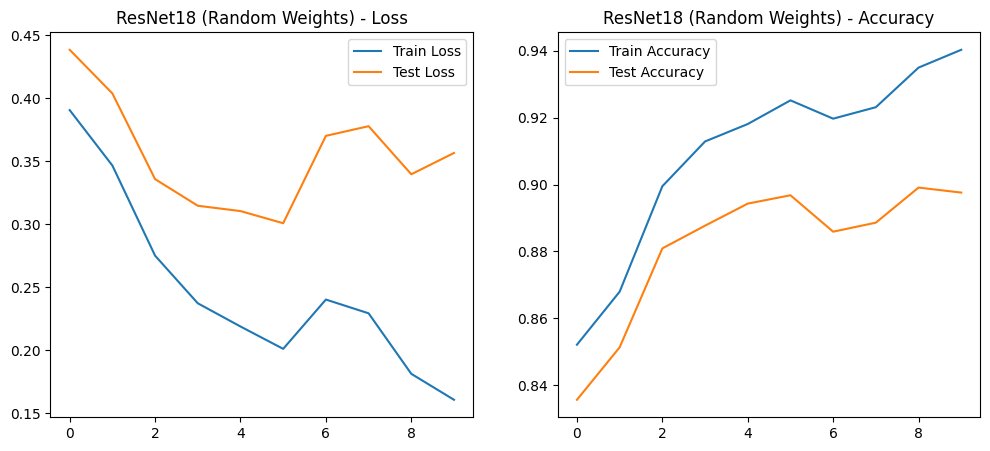

In [ ]:
##############################
# Step 1: ResNet18 with RANDOM weights

resnet_random = models.resnet18(weights=None)
resnet_random.fc = nn.Linear(512, 10)
resnet_random = resnet_random.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_random.parameters(), lr=1e-3)
r1_train_loss, r1_train_acc, r1_test_loss, r1_test_acc = train_loop(
    train_dataloader, test_dataloader, resnet_random, loss_fn, optimizer, epochs=10
)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(r1_train_loss, label="Train Loss")
plt.plot(r1_test_loss, label="Test Loss")
plt.title("ResNet18 (Random Weights) - Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(r1_train_acc, label="Train Accuracy")
plt.plot(r1_test_acc, label="Test Accuracy")
plt.title("ResNet18 (Random Weights) - Accuracy")
plt.legend()
plt.show()


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


Epoch 1:

loss: 2.797374  [   64/60000]
loss: 0.431200  [ 6464/60000]
loss: 0.383486  [12864/60000]
loss: 0.370769  [19264/60000]
loss: 0.470808  [25664/60000]
loss: 0.445468  [32064/60000]
loss: 0.278177  [38464/60000]
loss: 0.378140  [44864/60000]
loss: 0.286243  [51264/60000]
loss: 0.199164  [57664/60000]
Train Error: 
 Accuracy: 87.7%, Avg loss: 0.333462 

Test Error: 
 Accuracy: 86.5%, Avg loss: 0.375406 

Epoch 2:

loss: 0.266345  [   64/60000]
loss: 0.255434  [ 6464/60000]
loss: 0.232757  [12864/60000]
loss: 0.271400  [19264/60000]
loss: 0.346925  [25664/60000]
loss: 0.371192  [32064/60000]
loss: 0.219305  [38464/60000]
loss: 0.320890  [44864/60000]
loss: 0.240184  [51264/60000]
loss: 0.181378  [57664/60000]
Train Error: 
 Accuracy: 90.4%, Avg loss: 0.255559 

Test Error: 
 Accuracy: 89.1%, Avg loss: 0.297758 

Epoch 3:

loss: 0.223503  [   64/60000]
loss: 0.202095  [ 6464/60000]
loss: 0.251659  [12864/60000]
loss: 0.220583  [19264/60000]
loss: 0.346812  [25664/60000]
loss: 0.34

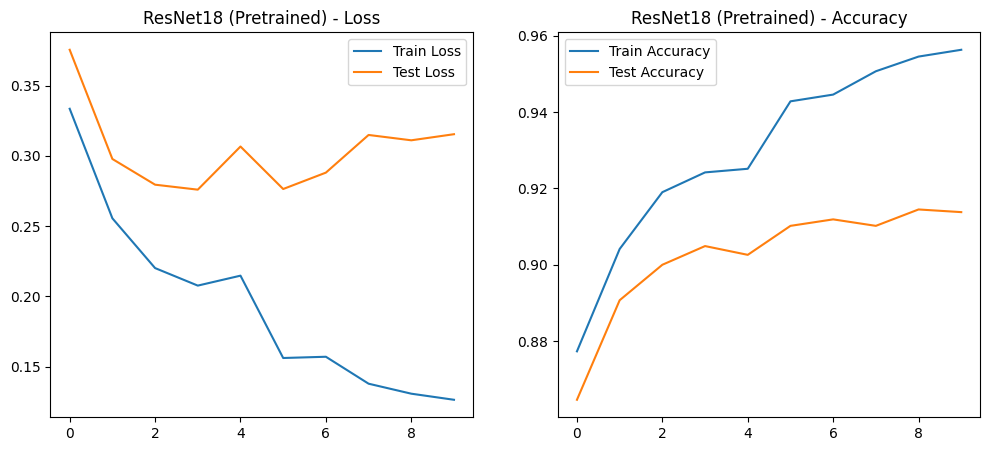

In [ ]:
##############################
# Step 2: ResNet18 with default parameters

resnet_pretrained = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_pretrained.fc = nn.Linear(512, 10)
resnet_pretrained = resnet_pretrained.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_pretrained.parameters(), lr=1e-3)
r2_train_loss, r2_train_acc, r2_test_loss, r2_test_acc = train_loop(
    train_dataloader, test_dataloader, resnet_pretrained, loss_fn, optimizer, epochs=10
)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(r2_train_loss, label="Train Loss")
plt.plot(r2_test_loss, label="Test Loss")
plt.title("ResNet18 (Pretrained) - Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(r2_train_acc, label="Train Accuracy")
plt.plot(r2_test_acc, label="Test Accuracy")
plt.title("ResNet18 (Pretrained) - Accuracy")
plt.legend()
plt.show()


Epoch 1:

loss: 2.836590  [   64/60000]
loss: 1.258418  [ 6464/60000]
loss: 0.887147  [12864/60000]
loss: 1.029223  [19264/60000]
loss: 1.008976  [25664/60000]
loss: 0.952359  [32064/60000]
loss: 0.877886  [38464/60000]
loss: 0.802171  [44864/60000]
loss: 1.101293  [51264/60000]
loss: 0.918081  [57664/60000]
Train Error: 
 Accuracy: 71.9%, Avg loss: 0.828245 

Test Error: 
 Accuracy: 70.6%, Avg loss: 0.858766 

Epoch 2:

loss: 0.884745  [   64/60000]
loss: 0.835135  [ 6464/60000]
loss: 0.760954  [12864/60000]
loss: 0.821849  [19264/60000]
loss: 0.859012  [25664/60000]
loss: 0.883572  [32064/60000]
loss: 0.818685  [38464/60000]
loss: 0.781668  [44864/60000]
loss: 1.074312  [51264/60000]
loss: 0.870167  [57664/60000]
Train Error: 
 Accuracy: 73.1%, Avg loss: 0.788031 

Test Error: 
 Accuracy: 71.5%, Avg loss: 0.829166 

Epoch 3:

loss: 0.866610  [   64/60000]
loss: 0.778799  [ 6464/60000]
loss: 0.746169  [12864/60000]
loss: 0.787029  [19264/60000]
loss: 0.809141  [25664/60000]
loss: 0.85

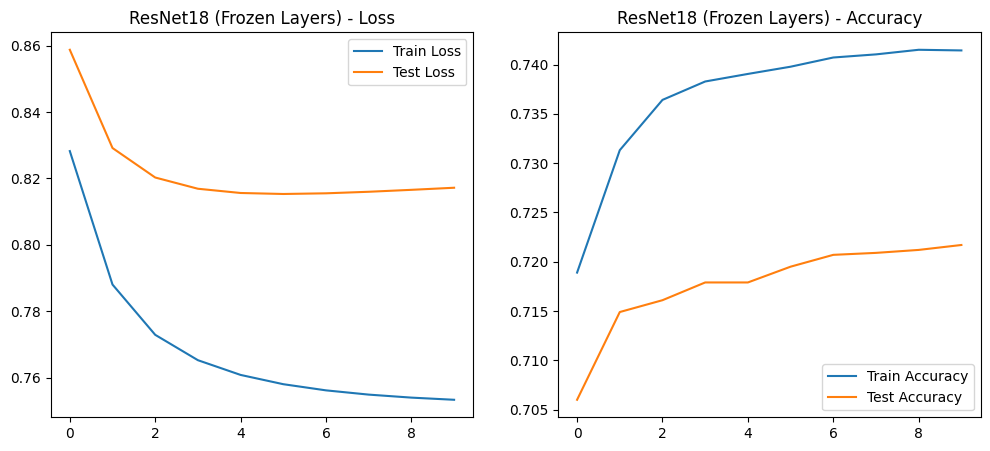

In [ ]:
##############################
# Step 3: ResNet18 with all layers FROZEN except last

resnet_frozen = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet_frozen.fc = nn.Linear(512, 10)
for param in resnet_frozen.parameters():
    param.requires_grad = False
for param in resnet_frozen.fc.parameters():
    param.requires_grad = True
resnet_frozen = resnet_frozen.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet_frozen.fc.parameters(), lr=1e-3)
r3_train_loss, r3_train_acc, r3_test_loss, r3_test_acc = train_loop(
    train_dataloader, test_dataloader, resnet_frozen, loss_fn, optimizer, epochs=10
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(r3_train_loss, label="Train Loss")
plt.plot(r3_test_loss, label="Test Loss")
plt.title("ResNet18 (Frozen Layers) - Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(r3_train_acc, label="Train Accuracy")
plt.plot(r3_test_acc, label="Test Accuracy")
plt.title("ResNet18 (Frozen Layers) - Accuracy")
plt.legend()
plt.show()


### <font color='red'>Your text here.</font>
<font color='red'>Enter your text descriptions in the cell below:</font>

What is the difference between the three approaches?

1. ResNet18 with Random Weights (Training from Scratch)

When we trained ResNet18 starting from completely random weights, the model learned slowly and didn’t reach very high accuracy. The test accuracy ended up around 89–90%, which is okay but not great for a deep network. This happened because ResNet18 is a large model and starting from random weights means it has to learn all features from scratch. Fashion-MNIST is too small to properly train such a big model, so the network struggles and shows mild overfitting (train accuracy > test accuracy).

2. ResNet18 with  default paramaters (ImageNet Features)

When we used the default pretrained weights, performance improved noticeably. The model started with strong feature extractors already learned from ImageNet, so it only had to adjust the final layer for Fashion-MNIST classes. The test accuracy increased to about 91–92%, and the loss curves were more stable. Pretrained models already know useful textures, edges, and shapes, so they learn faster and generalize better. This is the main benefit of transfer learning.

3. ResNet18 with Frozen Layers (Only Training the Last Layer)

In the frozen version, almost all of the model was locked, and only the last layer was trainable. This massively reduced the number of learnable parameters, which helps prevent overfitting — but it also limits performance. Because the early layers were trained for ImageNet (real-world images), they don’t fully match Fashion-MNIST (simple grayscale clothing images). As a result, accuracy dropped to around 72%, much worse than the other two approaches. The model couldn't adapt enough to the new problem because too many layers were frozen.